### Chest X-Ray Images (Pneumonia)
### Transfer Learning:ResNets

In [34]:
import pandas as pd       
import matplotlib as mat
import matplotlib.pyplot as plt    
import numpy as np
import seaborn as sns
%matplotlib inline

pd.options.display.max_colwidth = 100

import random
import os

from numpy.random import seed
seed(42)

random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import glob
import cv2

from tensorflow.random import set_seed
set_seed(42)

import warnings
warnings.filterwarnings('ignore')

### import donnée Chest X-Ray Images

In [2]:
IMG_SIZE = 224
BATCH = 32
SEED = 42

In [4]:
#main_path = "../input/chest-xray-pneumonia/chest_xray/"
main_path = "./chest_xray"


train_path = os.path.join(main_path,"train")
test_path=os.path.join(main_path,"test")

train_normal = glob.glob(train_path+"/NORMAL/*.jpeg")
train_pneumonia = glob.glob(train_path+"/PNEUMONIA/*.jpeg")

test_normal = glob.glob(test_path+"/NORMAL/*.jpeg")
test_pneumonia = glob.glob(test_path+"/PNEUMONIA/*.jpeg")

In [5]:
train_list = [x for x in train_normal]
train_list.extend([x for x in train_pneumonia])

df_train = pd.DataFrame(np.concatenate([['Normal']*len(train_normal) , ['Pneumonia']*len(train_pneumonia)]), columns = ['class'])
df_train['image'] = [x for x in train_list]

test_list = [x for x in test_normal]
test_list.extend([x for x in test_pneumonia])

df_test = pd.DataFrame(np.concatenate([['Normal']*len(test_normal) , ['Pneumonia']*len(test_pneumonia)]), columns = ['class'])
df_test['image'] = [x for x in test_list]

In [32]:
train_data=df_train

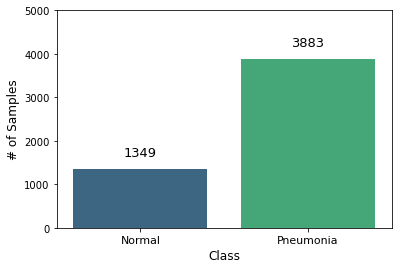

In [8]:
plt.figure(figsize=(6,4))

ax = sns.countplot(x='class', data=df_train, palette="viridis")

plt.xlabel("Class", fontsize= 12)
plt.ylabel("# of Samples", fontsize= 12)
plt.ylim(0,5000)
plt.xticks([0,1], ['Normal', 'Pneumonia'], fontsize = 11)

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.30, p.get_height()+300), fontsize = 13)
    
plt.show()

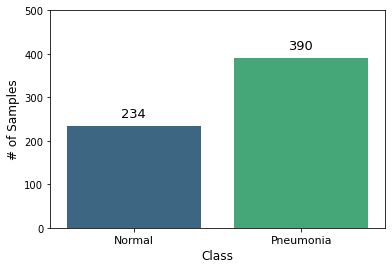

In [12]:
plt.figure(figsize=(6,4))

ax = sns.countplot(x='class', data=df_test, palette="viridis")

plt.xlabel("Class", fontsize= 12)
plt.ylabel("# of Samples", fontsize= 12)
plt.ylim(0,500)
plt.xticks([0,1], ['Normal', 'Pneumonia'], fontsize = 11)

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.32, p.get_height()+20), fontsize = 13)
    
plt.show()

In [10]:
train_df, val_df = train_test_split(df_train, test_size = 0.20, random_state = SEED, stratify = df_train['class'])

In [11]:
result=pd.concat([train_df,val_df,df_test],axis=0,keys=['train', 'validation', 'test'])

In [12]:
result

class                                                    image
train 3566  Pneumonia  ./chest_xray/train/PNEUMONIA/BACTERIA-9044474-0002.jpeg
      2866  Pneumonia     ./chest_xray/train/PNEUMONIA/VIRUS-6149071-0005.jpeg
      2681  Pneumonia  ./chest_xray/train/PNEUMONIA/BACTERIA-3309082-0001.jpeg
      1199     Normal       ./chest_xray/train/NORMAL/NORMAL-6433176-0001.jpeg
      4619  Pneumonia  ./chest_xray/train/PNEUMONIA/BACTERIA-6991447-0001.jpeg
...               ...                                                      ...
test  619   Pneumonia   ./chest_xray/test/PNEUMONIA/BACTERIA-9242636-0001.jpeg
      620   Pneumonia   ./chest_xray/test/PNEUMONIA/BACTERIA-1602272-0003.jpeg
      621   Pneumonia      ./chest_xray/test/PNEUMONIA/VIRUS-4360206-0001.jpeg
      622   Pneumonia      ./chest_xray/test/PNEUMONIA/VIRUS-3746644-0001.jpeg
      623   Pneumonia      ./chest_xray/test/PNEUMONIA/VIRUS-4190128-0001.jpeg

[5856 rows x 2 columns]

In [22]:
result1=result.reset_index()

<AxesSubplot:ylabel='level_0'>

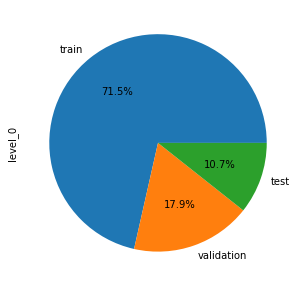

In [20]:
plt.figure(figsize=(7,5))
result1['level_0'].value_counts().plot(kind='pie', autopct='%1.1f%%', )


In [13]:
train_datagen = ImageDataGenerator(rescale=1/255.,
                                  zoom_range = 0.1,
                                  #rotation_range = 0.1,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1)

val_datagen = ImageDataGenerator(rescale=1/255.)

ds_train = train_datagen.flow_from_dataframe(train_df,
                                             #directory=train_path, #dataframe contains the full paths
                                             x_col = 'image',
                                             y_col = 'class',
                                             target_size = (IMG_SIZE, IMG_SIZE),
                                             class_mode = 'binary',
                                             batch_size = BATCH,
                                             seed = SEED)

ds_val = val_datagen.flow_from_dataframe(val_df,
                                            #directory=train_path,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = BATCH,
                                            seed = SEED)

ds_test = val_datagen.flow_from_dataframe(df_test,
                                            #directory=test_path,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = 1,
                                            shuffle = False)

Found 4185 validated image filenames belonging to 2 classes.
Found 1047 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


In [17]:
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=0.0000001,
    restore_best_weights=True,
)

plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.2,                                     
    patience = 2,                                   
    min_delt = 0.0000001,                                
    cooldown = 0,                               
    verbose = 1
) 

### Transfer Learning

### ResNet152V2

In [45]:
base_model = tf.keras.applications.ResNet152V2( #import modele ResnNet152
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False)

base_model.trainable = False

def get_pretrained():
    
    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    x = base_model(inputs)

    # Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    
    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=[inputs], outputs=output)
    
    return model

A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of ed17cf2e0169df9d443503ef94b23b33 so we will re-download the data.
234553344/234545216 [==============================] - 251s 1us/step


In [46]:
keras.backend.clear_session()

model_pretrained = get_pretrained()
model_pretrained.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=0.00005), metrics='binary_accuracy')

model_pretrained.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet152v2 (Functional)     (None, 7, 7, 2048)        58331648  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 58,594,049
Trainable params: 262,401
Non-trainable params: 58,331,648
___________________________________________

In [49]:
history = model_pretrained.fit(ds_train,
          batch_size = BATCH, epochs = 50,
          validation_data=ds_val,
          callbacks=[early_stopping, plateau],
          steps_per_epoch=(len(train_df)/BATCH),
          validation_steps=(len(val_df)/BATCH));

Epoch 1/50
130/130 [==============================] - 569s 4s/step - loss: 0.6299 - binary_accuracy: 0.6533 - val_loss: 0.2258 - val_binary_accuracy: 0.9226
Epoch 2/50
130/130 [==============================] - 564s 4s/step - loss: 0.2148 - binary_accuracy: 0.9211 - val_loss: 0.1647 - val_binary_accuracy: 0.9341
Epoch 3/50
130/130 [==============================] - 580s 4s/step - loss: 0.1813 - binary_accuracy: 0.9353 - val_loss: 0.1401 - val_binary_accuracy: 0.9503
Epoch 4/50
130/130 [==============================] - 585s 4s/step - loss: 0.1603 - binary_accuracy: 0.9373 - val_loss: 0.1356 - val_binary_accuracy: 0.9446
Epoch 5/50
130/130 [==============================] - 2464s 19s/step - loss: 0.1541 - binary_accuracy: 0.9438 - val_loss: 0.1205 - val_binary_accuracy: 0.9570
Epoch 6/50
130/130 [==============================] - 607s 5s/step - loss: 0.1429 - binary_accuracy: 0.9521 - val_loss: 0.1102 - val_binary_accuracy: 0.9637
Epoch 7/50
130/130 [==============================] - 58

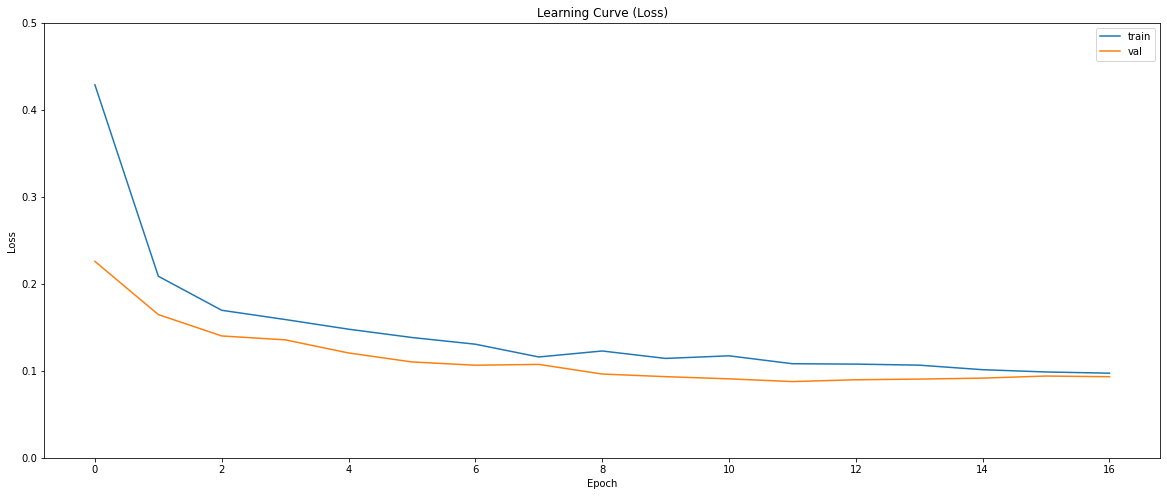

In [50]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['loss'])
sns.lineplot(x = history.epoch, y = history.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 0.5)
ax.legend(['train', 'val'], loc='best')
plt.show()

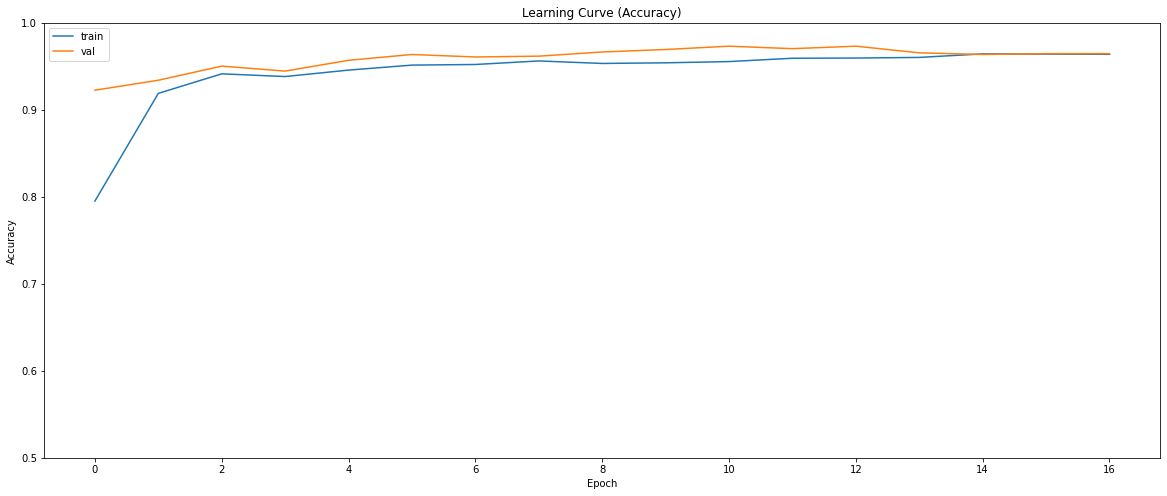

In [51]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['binary_accuracy'])
sns.lineplot(x = history.epoch, y = history.history['val_binary_accuracy'])
ax.set_title('Learning Curve (Accuracy)')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0.5, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

In [52]:
score = model.evaluate(ds_val, steps = len(val_df)/BATCH, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.15269556641578674
Val accuracy: 0.9283667802810669


In [53]:
score = model.evaluate(ds_test, steps = len(df_test), verbose = 0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.21785862743854523
Test accuracy: 0.9230769276618958


### Resnet50

In [20]:
base_model = tf.keras.applications.ResNet50(
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False)

base_model.trainable = False

def get_pretrained():
    
    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    x = base_model(inputs)

    # Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    
    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=[inputs], outputs=output)
    
    return model

In [21]:
keras.backend.clear_session()

model_pretrained = get_pretrained()
model_pretrained.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=0.00005), metrics='binary_accuracy')

model_pretrained.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 23,850,113
Trainable params: 262,401
Non-trainable params: 23,587,712
___________________________________________

In [43]:
history2 = model_pretrained.fit(ds_train,
          batch_size = BATCH, epochs = 15,
          validation_data=ds_val,
          callbacks=[early_stopping, plateau],
          steps_per_epoch=(len(train_df)/BATCH),
          validation_steps=(len(val_df)/BATCH));

Epoch 1/15
131/131 - 265s - loss: 0.4456 - accuracy: 0.7780 - precision: 0.8348 - recall: 0.8738 - val_loss: 0.3498 - val_accuracy: 0.8481 - val_precision: 0.9198 - val_recall: 0.8713
Epoch 2/15
131/131 - 273s - loss: 0.4237 - accuracy: 0.7866 - precision: 0.8450 - recall: 0.8725 - val_loss: 0.3083 - val_accuracy: 0.8606 - val_precision: 0.9029 - val_recall: 0.9099
Epoch 3/15
131/131 - 285s - loss: 0.4164 - accuracy: 0.7967 - precision: 0.8562 - recall: 0.8725 - val_loss: 0.3005 - val_accuracy: 0.8625 - val_precision: 0.8971 - val_recall: 0.9202
Epoch 4/15
131/131 - 291s - loss: 0.4045 - accuracy: 0.8096 - precision: 0.8692 - recall: 0.8751 - val_loss: 0.3334 - val_accuracy: 0.8271 - val_precision: 0.8191 - val_recall: 0.9846
Epoch 5/15
131/131 - 272s - loss: 0.3947 - accuracy: 0.8122 - precision: 0.8616 - recall: 0.8899 - val_loss: 0.4834 - val_accuracy: 0.7603 - val_precision: 0.9870 - val_recall: 0.6860
Epoch 6/15
131/131 - 275s - loss: 0.3927 - accuracy: 0.8177 - precision: 0.8718 

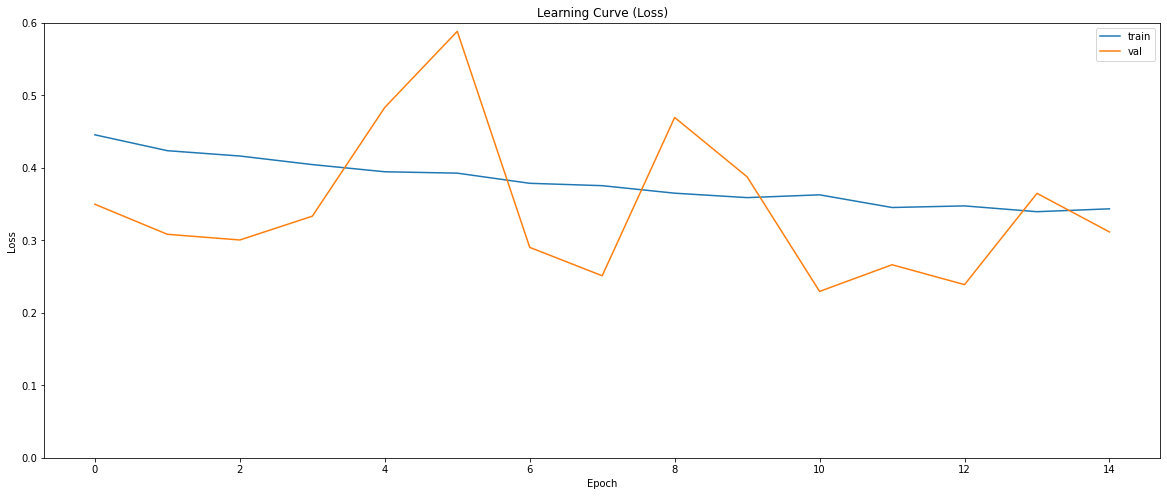

In [48]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history2.epoch, y = history2.history['loss'])
sns.lineplot(x = history2.epoch, y = history2.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 0.6)
ax.legend(['train', 'val'], loc='best')
plt.show()

In [51]:
score = model2.evaluate(ds_val, steps = len(val_df)/BATCH, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.31159037351608276
Val accuracy: 0.8242598176002502


In [52]:
score = model2.evaluate(ds_test, steps = len(df_test), verbose = 0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.6079294681549072
Test accuracy: 0.6714743375778198


### ResNet101

In [14]:
base_model = tf.keras.applications.ResNet101(
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False)

base_model.trainable = False

def get_pretrained():
    
    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    x = base_model(inputs)

    # Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    
    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=[inputs], outputs=output)
    
    return model

2021-10-28 18:19:37.032756: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


171450368/171446536 [==============================] - 6s 0us/step


In [15]:
keras.backend.clear_session()

model_pretrained = get_pretrained()
model_pretrained.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=0.00005), metrics='binary_accuracy')

model_pretrained.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet101 (Functional)       (None, 7, 7, 2048)        42658176  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 42,920,577
Trainable params: 262,401
Non-trainable params: 42,658,176
___________________________________________

In [19]:
history = model_pretrained.fit(ds_train,
          batch_size = BATCH, epochs = 15,
          validation_data=ds_val,
          callbacks=[early_stopping, plateau],
          steps_per_epoch=(len(train_df)/BATCH),
          validation_steps=(len(val_df)/BATCH));

Epoch 1/15
130/130 [==============================] - 502s 4s/step - loss: 0.5514 - binary_accuracy: 0.7422 - val_loss: 0.5358 - val_binary_accuracy: 0.7421
Epoch 2/15
130/130 [==============================] - 520s 4s/step - loss: 0.5363 - binary_accuracy: 0.7427 - val_loss: 0.5187 - val_binary_accuracy: 0.7421
Epoch 3/15
130/130 [==============================] - 524s 4s/step - loss: 0.5206 - binary_accuracy: 0.7424 - val_loss: 0.5038 - val_binary_accuracy: 0.7421
Epoch 4/15
130/130 [==============================] - 620s 5s/step - loss: 0.5059 - binary_accuracy: 0.7419 - val_loss: 0.4925 - val_binary_accuracy: 0.7421
Epoch 5/15
130/130 [==============================] - 531s 4s/step - loss: 0.4946 - binary_accuracy: 0.7443 - val_loss: 0.4772 - val_binary_accuracy: 0.7450
Epoch 6/15
130/130 [==============================] - 554s 4s/step - loss: 0.4804 - binary_accuracy: 0.7467 - val_loss: 0.4653 - val_binary_accuracy: 0.7488
Epoch 7/15
130/130 [==============================] - 2750

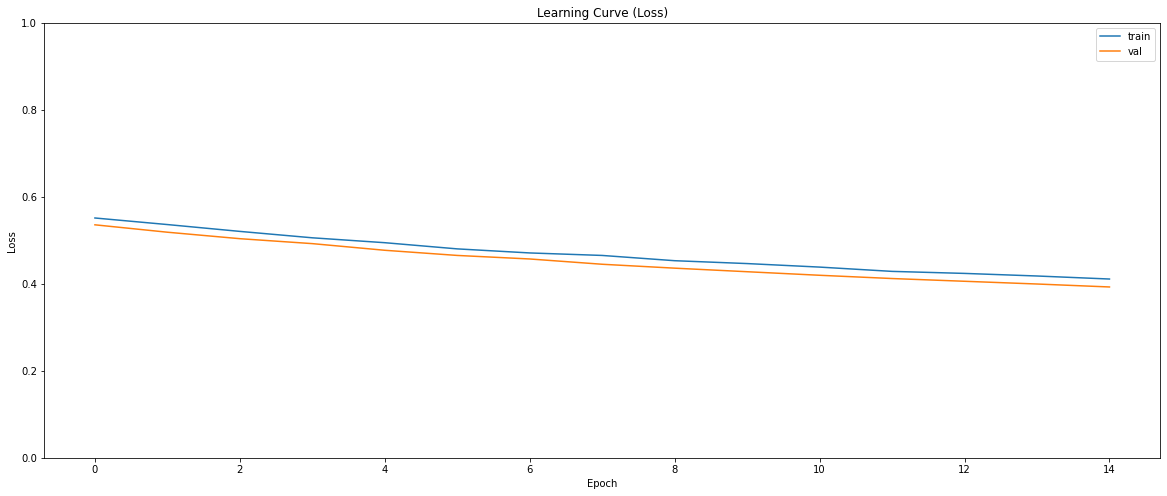

In [23]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['loss'])
sns.lineplot(x = history.epoch, y = history.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 1)
ax.legend(['train', 'val'], loc='best')
plt.show()

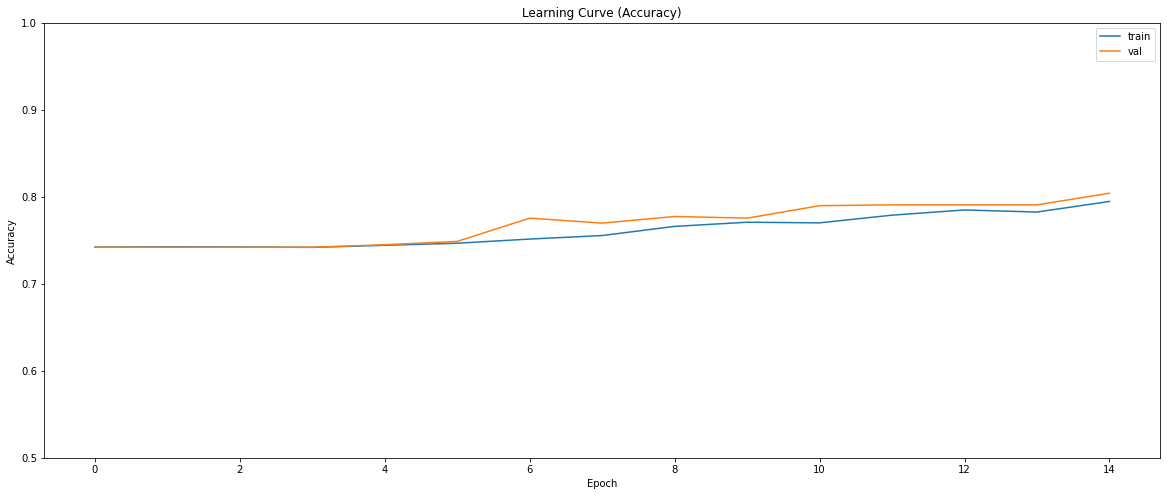

In [24]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['binary_accuracy'])
sns.lineplot(x = history.epoch, y = history.history['val_binary_accuracy'])
ax.set_title('Learning Curve (Accuracy)')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0.5, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

In [29]:
score = model_pretrained.evaluate(ds_val, steps = len(val_df)/BATCH, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.7812575697898865
Val accuracy: 0.2578796446323395


In [28]:
score = model_pretrained.evaluate(ds_test, steps = len(df_test), verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.7430514097213745
Test accuracy: 0.375


### VGG

#### Using pre-trained VGG-16 model.
#### Freezing all the layers of model to train.
#### Using RMSProp as optimiser
#### Also using learning rate decay to optimize the learning process.

In [41]:
conv_base = keras.applications.VGG16(include_top = False,weights='imagenet')
for i in conv_base.layers:
    i.trainable=False
X = conv_base.output
X = keras.layers.GlobalAveragePooling2D()(X)
X = keras.layers.Dense(128,activation='relu')(X)
predictions = keras.layers.Dense(1,activation='sigmoid')(X)
model= keras.Model(conv_base.input,predictions)
initial_learning_rate = 0.1
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)
model.compile(loss='binary_crossentropy',
             optimizer=tf.keras.optimizers.RMSprop(lr_schedule),
             metrics=['accuracy'])

58892288/58889256 [==============================] - 1s 0us/step


In [42]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

In [43]:
history = model.fit(ds_train,
          batch_size = BATCH, epochs = 15,
          validation_data=ds_val,
          steps_per_epoch=(len(train_df)/BATCH),
          validation_steps=(len(val_df)/BATCH));

Epoch 1/15
130/130 [==============================] - 1323s 10s/step - loss: 3.4698 - accuracy: 0.6944 - val_loss: 0.2574 - val_accuracy: 0.9064
Epoch 2/15
130/130 [==============================] - 577s 4s/step - loss: 0.3138 - accuracy: 0.8672 - val_loss: 0.1766 - val_accuracy: 0.9379
Epoch 3/15
130/130 [==============================] - 1119s 9s/step - loss: 0.2862 - accuracy: 0.8855 - val_loss: 0.1511 - val_accuracy: 0.9542
Epoch 4/15
130/130 [==============================] - 1318s 10s/step - loss: 0.2698 - accuracy: 0.8962 - val_loss: 0.1604 - val_accuracy: 0.9417
Epoch 5/15
130/130 [==============================] - 571s 4s/step - loss: 0.2460 - accuracy: 0.9085 - val_loss: 0.1332 - val_accuracy: 0.9580
Epoch 6/15
130/130 [==============================] - 574s 4s/step - loss: 0.2485 - accuracy: 0.9087 - val_loss: 0.1736 - val_accuracy: 0.9312
Epoch 7/15
130/130 [==============================] - 605s 5s/step - loss: 0.2104 - accuracy: 0.9254 - val_loss: 0.1658 - val_accuracy: 0

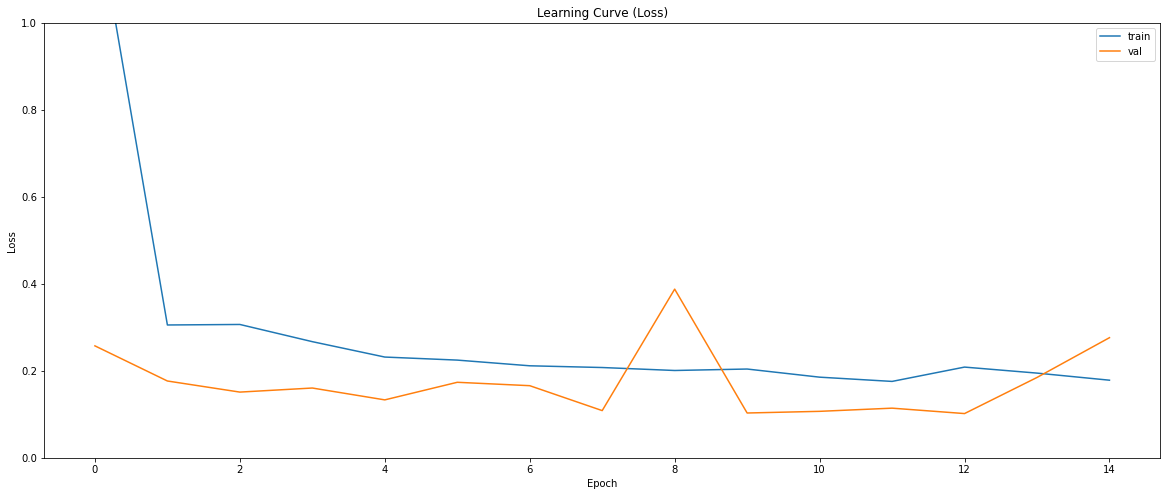

In [44]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['loss'])
sns.lineplot(x = history.epoch, y = history.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 1)
ax.legend(['train', 'val'], loc='best')
plt.show()

In [46]:
score = model_pretrained.evaluate(ds_val, steps = len(val_df)/BATCH, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.7812575697898865
Val accuracy: 0.2578796446323395


In [48]:
score = model_pretrained.evaluate(ds_test, steps = len(df_test), verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.7430514097213745
Test accuracy: 0.375
